In [1]:
%matplotlib inline

#import notebook
#from notebook.nbextensions import enable_nbextension
#enable_nbextension('notebook', 'usability/codefolding/main')
import numpy as np
import matplotlib.pyplot as mp
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import markdown
#import scipy.stats as stats
import sys
sys.path.append('/Users/vs/Dropbox/Python')
sys.path.append('/Users/vs/Dropbox/Python/gloess/')
import shutil
import glob
import re
import os
import gloess_fits as gf
import linecache
import numpy.ma as ma
import matplotlib.gridspec as gridspec


#import reddening_laws as red
bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
mp.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

# galactic_multiwavelength_cepheids

* Takes a list of Cepheids and periods
* reads in the gloess files
* Does gloess fits to all bands
* Produces an output file with name, period, (average mag, average error, amplitude) for all bands
* NaNs represented by 99.999 in the output file

To impliment:
- Read in an existing Galactic_Cepheids_averages file rather than starting from a NaN filled file and update the values
- This way you can run only stars that need to be refit rather than the whole sample, and add new stars as needed.
- Add this as an option/switch?

In [101]:
### List of targets with periods
gal_df = pd.read_csv('/Users/vs/Dropbox/CHP/Galactic_Cepheids/Galactic_Cepheids_List', delimiter='&', header=None, names=('Cepheid', 'logP'))
#gal_df = pd.read_csv('/Users/vs/Dropbox/CHP/Galactic_Cepheids/to_refit', delimiter='&', header=None, names=('Cepheid', 'logP'))

#gal_df = pd.read_csv('/Users/vs/Dropbox/CHP/Galactic_Cepheids/Galactic_Cepheids_averages', delim_whitespace=True, header=0)

### Set working directory

os.chdir('/Users/vs/Dropbox/CHP/Galactic_Cepheids/')

### Don't need to strip whitespace from name (should probably fix naming of files in the directories)
### Change names to all caps to match with filenames

In [102]:
### Converting names to string so I can reformat them properly
gal_df['Cepheid'] = gal_df['Cepheid'].astype('str') 

In [103]:
gal_df

,Cepheid,logP
0,RT Aur,0.571489
1,QZ Nor,0.578244
2,SU Cyg,0.584952
3,Y Lac,0.635863
4,T Vul,0.646934
5,FF Aql,0.650397
6,T Vel,0.666501
7,VZ Cyg,0.687034
8,V350 Sgr,0.712165
9,BG Lac,0.726883


In [104]:
mag_columns = []
err_columns = []
cols = ['mjd']
bands = ['U', 'B', 'V', 'R', 'I', 'J', 'H', 'K', '3p6', '4p5', '5p8', '8p0']
for wlen in np.arange(len(bands)):
    mag_name = ('mag_' + str(bands[wlen]))
    err_name = ('err_' + str(bands[wlen]))
    mag_columns.append(mag_name)
    err_columns.append(err_name)
    cols.append(mag_name)
    cols.append(err_name)
    
cols.append('Reference')
#cols


gloess_setup(cepheid)
---
Fuction to setup the gloess input files

cepheid = cepheid name

Currently implimented:
* '-' sign as comment symbol -- removes crappy lines that are in the All_Cepheids_Ever database

To impliment:
* Check for incorrect number of fields
* replace '0.00' mag with '9.99' error with '99.99' mag with '9.99' error. 
 - This is a typo in the archival database
 - Should only do this for the archival files?
 - Anything with 9.99 error is generally shit anyway (has no error bar) so safe to do so.
 

all_the_gloess(row)
---

Fuction to run gloess on a given Cepheid taking information from *row* in a dataframe (name and period) and populating *row*  with the output of gloess (average mags, average errors, amplitudes for each band where there is data)

Input is *row* so should be run on a larger dataframe using apply() or just fed one row of a dataframe

This is probably the place where I can impliment the "replace '0.00' mag with '9.99' error with '99.99' mag with '9.99' error." step right now ---> otherwise do it in the "add_new_data_to_gloess_database" notebook when it's doing serious cleaning of the files.

Neither this function or gloess_setup() change the gloess input files on disk (intentionally)

In [105]:
### Going to copy the gloess input files to here, do some editing on them, (periods, cleaning the data) then run gloess
### Setting comment symbol = '-' to remove lines that start with '-'

def gloess_setup(cepheid):
    mag_columns = []
    err_columns = []
    cols = ['MJD']
    bands = ['U', 'B', 'V', 'R', 'I', 'J', 'H', 'K', '3p6', '4p5', '5p8', '8p0']
    for wlen in np.arange(len(bands)):
        mag_name = ('mag_' + str(bands[wlen]))
        err_name = ('err_' + str(bands[wlen]))
        mag_columns.append(mag_name)
        err_columns.append(err_name)
        cols.append(mag_name)
        cols.append(err_name)
    
    cols.append('Reference')

    cap_cepheid = str.upper(cepheid)
    orig_file = '/Users/vs/Dropbox/All_Cepheids_ever/MilkyWay/cepheids/' + cap_cepheid
    cepID = re.sub(' ', '', cepheid)
    new_file  = cepID + '.gloess_in'
    old_file = os.path.exists(orig_file)
    is_there = os.path.exists(new_file)

    if (old_file == False):
        if (is_there == False):
            period = 10**(avs_df.logP[avs_df['cepID']==cepID].values)
            smooth = '0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10'
            with open(new_file, 'w') as f:
                f.write("{0:s}\n".format(cepheid))
                f.write("{0:s}\n".format(period))
                f.write("0\n")
                f.write("{0:s}\n".format(smooth))

    if (is_there == False):
        shutil.copy(orig_file, new_file)
    linecache.clearcache()
    smooth_line = linecache.getline(new_file, 4).strip()
    smooth_line = re.sub("[\[\]\'\",]"," ", smooth_line)
    smooth = smooth_line.split()
    df = pd.read_csv(new_file, header=None, skiprows=4, names=(cols), comment='-', delim_whitespace=True)
    return(cepID, df, smooth)


In [167]:
def all_the_gloess(row):
    cepID, df, sm_params = gloess_setup(row['Cepheid'])
    #print sm_params
    name = row.Cepheid
    period = 10**(row.logP)
    df['phase'] = (df['MJD'] / period) - np.floor(df['MJD'] / period)
    print name, period, sm_params
    bands = ['U', 'B', 'V', 'R', 'I', 'J', 'H', 'K', '3p6', '4p5', '5p8', '8p0']
    offsets= [3, 1.5, 1.2, 0.7, 0.2, 0, -0.4, -0.8, -1.4, -1.8, -2.2, -2.6]
    colors = ['Violet', 'MediumSlateBlue', 'DodgerBlue', 'Turquoise', 'LawnGreen', 'Gold', 'DarkOrange', 'Red', 'MediumVioletRed', 'DeepPink', 'HotPink', 'PeachPuff']
    av_mags = np.zeros(12) + np.nan   
    av_errs = np.zeros(12) + np.nan   
    av_amps = np.zeros(12) + np.nan   
    mp.close()
    mp.clf()
    max_cur = 0
    min_cur = 99
    fig = mp.figure(figsize=(10,10))
    ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.8])    
    titlestring = name + ', P = ' + str(np.round(period, decimals=4)) + ' days'
    mp.title(titlestring, fontsize=20)
    ax1.set_ylabel('Magnitude')
    ax1.set_xlabel('Phase $\phi$')

    for band in np.arange(len(bands)):
        mag = 'mag_' + str(bands[band])
        err = 'err_' + str(bands[band])
        amplitude = 'amp_' + str(bands[band])
        ## Removing photographic data of unknown photometric system
        df.loc[df['Reference']=='1958BAN....14...81W', mag] = np.nan
        df.loc[df['Reference']=='1982PASP...94..182C', mag] = np.nan
        df.loc[df['Reference']=='1978AJ.....83.1397G', mag] = np.nan
        df.loc[df['Reference']=='1951ApJ...113..367E', mag] = np.nan
        df.loc[df['Reference']=='1961ApJS....6..253I', mag] = np.nan
        df.loc[df['Reference']=='1957MNRAS.117..406E', mag] = np.nan
        df.loc[df['Reference']=='1973AJ.....78..618W', mag] = np.nan
        df.loc[df['Reference']=='1968CoLPL..7....57W', mag] = np.nan
        df.loc[df['Reference']=='1985ApJ...295..507G', mag] = np.nan


        ## Can't locate this reference in ADS
        df.loc[df['Reference']=='1977MSuAW..70.....S', mag] = np.nan
        df.loc[df['Reference']=='10', mag] = np.nan
        df.loc[df['Reference']=='990', mag] = np.nan

        ## Removing data taken in the Johnson system
        if (bands[band] == 'R' or bands[band] == 'I'):
            df.loc[df['Reference']=='1984ApJS...55..389M', mag] = np.nan
            df.loc[df['Reference']=='1997PASP..109..645B', mag] = np.nan
            df.loc[df['Reference']=='1998MNRAS.297..825K', mag] = np.nan
            df.loc[df['Reference']=='1968CoLPL...7...57W', mag] = np.nan
            df.loc[df['Reference']=='1977ApJS...34....1E', mag] = np.nan
            df.loc[df['Reference']=='1986PZ.....22..369B', mag] = np.nan
            df.loc[df['Reference']=='1987PZ.....22..530B', mag] = np.nan
            df.loc[df['Reference']=='1992A&AT....2....1B', mag] = np.nan
            df.loc[df['Reference']=='1992A&AT....2...31B', mag] = np.nan
            df.loc[df['Reference']=='1992A&AT....2...43B', mag] = np.nan
            df.loc[df['Reference']=='1992A&AT....2..107B', mag] = np.nan
            df.loc[df['Reference']=='1992A&AT....2..157B', mag] = np.nan
            df.loc[df['Reference']=='1992A+AT....2....1B', mag] = np.nan
            df.loc[df['Reference']=='1992A+AT....2...31B', mag] = np.nan
            df.loc[df['Reference']=='1992A+AT....2...43B', mag] = np.nan
            df.loc[df['Reference']=='1992A+AT....2..107B', mag] = np.nan
            df.loc[df['Reference']=='1992A+AT....2..157B', mag] = np.nan
            df.loc[df['Reference']=='1992PAZh...18..325B', mag] = np.nan
            df.loc[df['Reference']=='1993PAZh...19..210B', mag] = np.nan
            df.loc[df['Reference']=='1994A+AT....5..317B', mag] = np.nan  
            df.loc[df['Reference']=='1994A&AT....5..317B', mag] = np.nan  
            df.loc[df['Reference']=='1994IBVS.3991....1B', mag] = np.nan    
            df.loc[df['Reference']=='1995IBVS.4141....1B', mag] = np.nan   
            df.loc[df['Reference']=='1998A+AT...16..291B', mag] = np.nan
            df.loc[df['Reference']=='1971ApJ...165..335S', mag] = np.nan       
            df.loc[df['Reference']=='1979PASP...91...67F', mag] = np.nan
            df.loc[df['Reference']=='1981ApJS...47..315G', mag] = np.nan
            df.loc[df['Reference']=='1995PAZh...21..803B', mag] = np.nan


        ### Removing non-IRAC data from the 3.6um columns
        if (bands[band] == '3p6'):
            df.loc[df['Reference']=='1992A&AS...93...93L', mag] = np.nan
            df.loc[df['Reference']=='1968CoLPL..7....57W', mag] = np.nan
            
        ### Removing data where mag=0 and error=9.99
        #if (df.loc[df[err]==9.99, mag] == 0):
        df.loc[df[mag]==0.00, mag] = np.nan        
        #df.loc[mag==0.00, err==9.99]
        
        ### Attempting dynamic smoothing parameters

        smooth = float(sm_params[band])
        
        pullmags = df[mag]
        n_good = len(pullmags < 50)
        #if (n_good <= 5):
        #    smooth = 1
        #elif (n_good >= 50):
        #    smooth = 0.1
        pullerrs = df[err]
        pullphase = df['phase']
        
        data1, x, y, yerr, xphase = gf.fit_one_band(df[mag], df[err], df['phase'],len(df[mag]) ,smooth)
        
        ave, adev, sdev, var, skew, kurtosis, amp = gf.moment(data1[200:300],100)
        #print ave, (sdev/(np.sqrt(len(data1)))), amp
        
        gal_df.ix[gal_df.Cepheid==name, mag]=ave
        gal_df.ix[gal_df.Cepheid==name, err]=sdev/(np.sqrt(len(data1)))
        gal_df.ix[gal_df.Cepheid==name, amplitude]=amp
        av_mags[band] = ave
        av_errs[band] = sdev/(np.sqrt(len(data1)))
        av_amps[band] = amp
               
        plotmag = pullmags[pullmags<50]
        plotphase = pullphase[pullmags<50]

        plotmag = np.concatenate((plotmag,plotmag,plotmag,plotmag,plotmag))
        plotphase = np.concatenate((plotphase,(plotphase+1.0),(plotphase+2.0),(plotphase+3.0),(plotphase+4.0)))
        size_of_data = len(plotmag)
        
        if np.sign(offsets[band]) == -1: 
            offstring = ' - ' + str(abs(offsets[band]))
        elif np.sign(offsets[band]) == 0: 
            offstring = ''
        else:
            offstring = ' + ' + str(offsets[band])
        lab_text = str(bands[band]) + str(offstring)
        ax1.plot(x,data1+offsets[band],'k-', zorder=4)
        ax1.plot(plotphase, plotmag+offsets[band],color=colors[band],marker='o',ls='None', label=lab_text)
        maxval = np.max(data1[200:300]+offsets[band])
        minval = np.min(data1[200:300]+offsets[band])
        if(maxval > max_cur):
            max_cur = maxval
        if(minval < min_cur):
            min_cur = minval

        
    maxlim = max_cur + 1.5
    minlim = min_cur - 1.5
    ax1.axis([1,3.5,(maxlim),(minlim)])
    handles, labels = ax1.get_legend_handles_labels() 
    mp.legend(handles[::-1],labels[::-1], numpoints=1,prop={'size':10})
    mp.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    mp.savefig(cepID + '.pdf')
    bands_df = pd.DataFrame(bands)
    bands_df.columns = ['Band']
    av_mags_df = pd.DataFrame(av_mags)
    av_mags_df.columns = ['AverageMag']
    av_errs_df = pd.DataFrame(av_errs)
    av_errs_df.columns = ['AverageErr']
    av_amps_df = pd.DataFrame(av_amps)
    av_amps_df.columns = ['AverageAmp']


    cep_out_df = pd.concat([bands_df, av_mags_df, av_errs_df, av_amps_df], axis=1, ignore_index=True)
    print cep_out_df

In [168]:
### Only run if not reading previous output

av_cols = []
bands = ['U', 'B', 'V', 'R', 'I', 'J', 'H', 'K', '3p6', '4p5', '5p8', '8p0']
for wlen in np.arange(len(bands)):
    mag_name = ('mag_' + str(bands[wlen]))
    err_name = ('err_' + str(bands[wlen]))
    amp_name = ('amp_' + str(bands[wlen]))
    av_cols.append(mag_name)
    av_cols.append(err_name)
    av_cols.append(amp_name)
av_cols

for columns in np.arange(len(av_cols)):
    gal_df[av_cols[columns]] = np.nan
    

#### Sort out some poorly formatted names
gal_df.Cepheid = gal_df.Cepheid.str.strip()
gal_df.ix[10, 'Cepheid'] = 'Delta Cep'
gal_df.ix[21, 'Cepheid'] = 'Eta Aql'
gal_df.ix[28, 'Cepheid'] = 'Beta Dor'
gal_df.ix[29, 'Cepheid'] = 'Zeta Gem'


In [112]:
### Not yet implimented
#ceps_to_do = pd.read_csv('/Users/vs/Dropbox/CHP/Galactic_Cepheids/to_refit', delimiter='&', header=None, names=('Cepheid', 'logP'))
#### Sort out some poorly formatted names
#ceps_to_do.Cepheid = ceps_to_do.Cepheid.str.strip()

#ceps_to_do['Cepheid'] = ceps_to_do['Cepheid'].map(lambda x: re.sub('[\$\\\~]', '', x))
#ceps_to_do['caps'] = ceps_to_do['Cepheid'].map(lambda x: str.upper(str.upper(x)))
#gal_df['caps'] = gal_df['Cepheid'].map(lambda x: str.upper(str.upper(x)))
#ceps_to_do['Refit'] = True


In [75]:
#ceps_to_do

,Cepheid,logP,caps,Refit
0,BB Sgr,0.821971,BB SGR,True
1,BG Lac,0.726883,BG LAC,True
2,BN Pup,1.135867,BN PUP,True
3,CV Mon,0.730685,CV MON,True
4,delta Cep,0.729678,DELTA CEP,True
5,eta Aql,0.855930,ETA AQL,True
6,FF Aql,0.650397,FF AQL,True
7,RT Aur,0.571489,RT AUR,True
8,RU Sct,1.294480,RU SCT,True
9,RZ Vel,1.309564,RZ VEL,True


In [88]:
#do_these_df = pd.merge(gal_df, ceps_to_do, how='outer', on=['caps', 'caps'])

#do_these_df = do_these_df.drop(['Cepheid_y', 'logP_y', 'caps'], 1)
#do_these_df = do_these_df.rename(columns={'Cepheid_x':'Cepheid', 'logP_x': 'logP'})
#do_these_df

,Cepheid,logP,mag_U,err_U,amp_U,mag_B,err_B,amp_B,mag_V,err_V,...,mag_4p5,err_4p5,amp_4p5,mag_5p8,err_5p8,amp_5p8,mag_8p0,err_8p0,amp_8p0,Refit
0,RT Aur,0.571,6.609,0.020,1.354,6.144,0.016,1.085,5.508,0.011,...,3.850,0.003,0.195,99.99,99.99,99.99,99.99,99.99,99.99,True
1,QZ Nor,0.578,10.437,0.008,0.482,9.782,0.007,0.437,8.875,0.004,...,99.990,99.990,99.990,99.99,99.99,99.99,99.99,99.99,99.99,NaN
2,SU Cyg,0.585,7.820,0.016,1.074,7.491,0.015,1.015,6.891,0.011,...,99.990,99.990,99.990,99.99,99.99,99.99,99.99,99.99,99.99,True
3,Y Lac,0.636,10.409,0.018,1.142,9.921,0.016,1.033,9.163,0.011,...,99.990,99.990,99.990,99.99,99.99,99.99,99.99,99.99,99.99,True
4,T Vul,0.647,6.823,0.017,1.076,6.443,0.014,0.970,5.773,0.009,...,4.112,0.003,0.172,99.99,99.99,99.99,99.99,99.99,99.99,True
5,FF Aql,0.650,6.656,0.009,0.557,6.158,0.007,0.475,5.383,0.005,...,3.354,0.001,0.064,99.99,99.99,99.99,99.99,99.99,99.99,True
6,T Vel,0.667,9.644,0.017,1.207,8.949,0.013,0.929,8.047,0.009,...,99.990,99.990,99.990,99.99,99.99,99.99,99.99,99.99,99.99,True
7,VZ Cyg,0.687,10.524,0.019,1.250,9.898,0.015,1.014,8.980,0.010,...,99.990,99.990,99.990,99.99,99.99,99.99,99.99,99.99,99.99,True
8,V350 Sgr,0.712,9.087,0.020,1.337,8.446,0.015,1.059,7.500,0.010,...,99.990,99.990,99.990,99.99,99.99,99.99,99.99,99.99,99.99,NaN
9,BG Lac,0.727,10.555,0.017,1.129,9.880,0.013,0.880,8.899,0.009,...,99.990,99.990,99.990,99.99,99.99,99.99,99.99,99.99,99.99,True


In [169]:
gal_df

,Cepheid,logP,mag_U,err_U,amp_U,mag_B,err_B,amp_B,mag_V,err_V,...,amp_3p6,mag_4p5,err_4p5,amp_4p5,mag_5p8,err_5p8,amp_5p8,mag_8p0,err_8p0,amp_8p0
0,RT Aur,0.571489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QZ Nor,0.578244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SU Cyg,0.584952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Y Lac,0.635863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T Vul,0.646934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,FF Aql,0.650397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,T Vel,0.666501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,VZ Cyg,0.687034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,V350 Sgr,0.712165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BG Lac,0.726883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RT Aur 3.72811242098 ['0.10', '0.10', '0.10', '1.0', '0.25', '0.25', '0.20', '0.20', '0.20', '0.20', '0.20', '0.20']
      0         1         2         3
0     U  6.555253  0.018432  1.372911
1     B  6.119702  0.016874  1.149208
2     V  5.486896  0.010980  0.744086
3     R  5.297159  0.000367  0.035163
4     I  4.822095  0.006478  0.397277
5     J  4.249132  0.003538  0.242057
6     H  3.979563  0.002243  0.153669
7     K  3.920510  0.002267  0.156476
8   3p6  3.852247  0.002597  0.168595
9   4p5  3.850445  0.002970  0.194724
10  5p8       NaN       NaN       NaN
11  8p0       NaN       NaN       NaN
QZ Nor 3.78655265143 ['0.40', '0.10', '0.10', '0.30', '0.10', '0.20', '0.20', '0.20', '0.20', '0.20', '0.20', '0.20']
      0          1         2         3
0     U  10.431928  0.005949  0.401586
1     B   9.782436  0.006695  0.436861
2     V   8.875280  0.004498  0.289362
3     R   8.388219  0.003283  0.216191
4     I   7.871162  0.002770  0.183470
5     J   7.137756  0.001857  0.12129

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
50    None
51    None
52    None
53    None
54    None
55    None
56    None
57    None
58    None
dtype: object

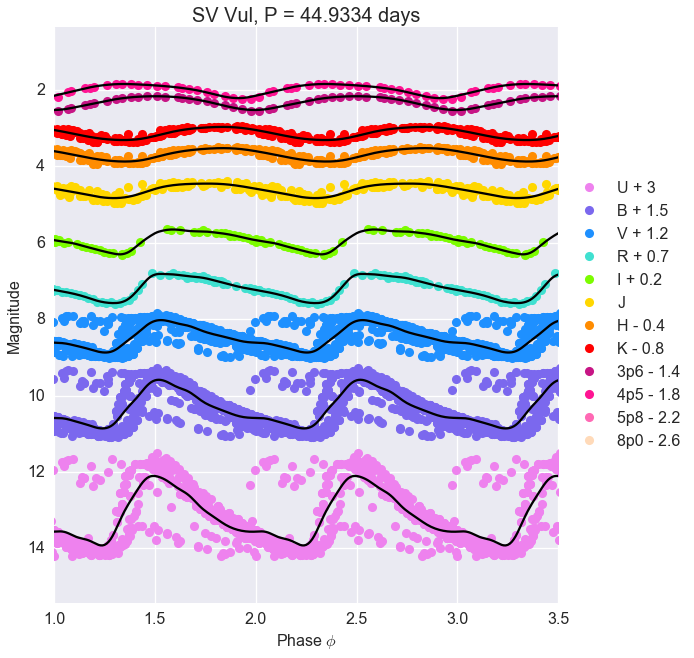

In [170]:
gal_df.apply(lambda line: all_the_gloess(line), axis=1)


In [171]:
gal_df

,Cepheid,logP,mag_U,err_U,amp_U,mag_B,err_B,amp_B,mag_V,err_V,...,amp_3p6,mag_4p5,err_4p5,amp_4p5,mag_5p8,err_5p8,amp_5p8,mag_8p0,err_8p0,amp_8p0
0,RT Aur,0.571489,6.555253,0.018432,1.372911,6.119702,0.016874,1.149208,5.486896,0.010980,...,0.168595,3.850445,0.002970,0.194724,NaN,NaN,NaN,NaN,NaN,NaN
1,QZ Nor,0.578244,10.431928,0.005949,0.401586,9.782436,0.006695,0.436861,8.875280,0.004498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SU Cyg,0.584952,7.806656,0.016098,1.081445,7.493239,0.015384,1.028812,6.889919,0.011002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Y Lac,0.635863,10.408782,0.017698,1.141545,9.921058,0.015776,1.033273,9.163281,0.010982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T Vul,0.646934,6.817389,0.016930,1.092284,6.443780,0.014351,0.968689,5.772270,0.009425,...,0.160022,4.112206,0.002691,0.171550,NaN,NaN,NaN,NaN,NaN,NaN
5,FF Aql,0.650397,6.647967,0.008542,0.554481,6.158705,0.007117,0.469201,5.383131,0.004876,...,0.064321,3.354155,0.001001,0.063954,NaN,NaN,NaN,NaN,NaN,NaN
6,T Vel,0.666501,9.633907,0.017448,1.190851,9.001338,0.013546,0.926035,8.047194,0.008934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,VZ Cyg,0.687034,10.541740,0.018475,1.233816,9.899806,0.014911,1.020135,8.983191,0.009794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,V350 Sgr,0.712165,9.084119,0.019563,1.318178,8.449262,0.015446,1.059283,7.503645,0.010354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BG Lac,0.726883,10.550078,0.016643,1.136852,9.877757,0.012943,0.877738,8.899852,0.008674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
gal_df.to_csv('Galactic_Cepheids_Averages', index=False, header=True, sep=' ', float_format='%4.3f', na_rep= 99.99)

In [261]:
period = 3.7281
df['phase'] = (df['MJD'] / period) - np.floor(df['MJD'] / period)
fit_mags = (df[mag].ix[df[mag]<99]).values
fit_errs = (df[err].ix[df[mag]<99]).values
fit_phases = (df['phase'].ix[df[mag]<99]).values
fit_len = len(fit_mags)
data1, x, y, yerr, xphase = gf.fit_one_band(fit_mags, fit_errs, fit_phases, fit_len,0.1)
ave, adev, sdev, var, skew, kurtosis, amp = gf.moment(data1[200:300],100)

In [262]:
mag = 'mag_3p6'
err = 'err_3p6'

In [263]:
ave, adev, sdev, var, skew, kurtosis, amp = gf.moment(data1[200:300],100)

120 120


(1, 2.5)

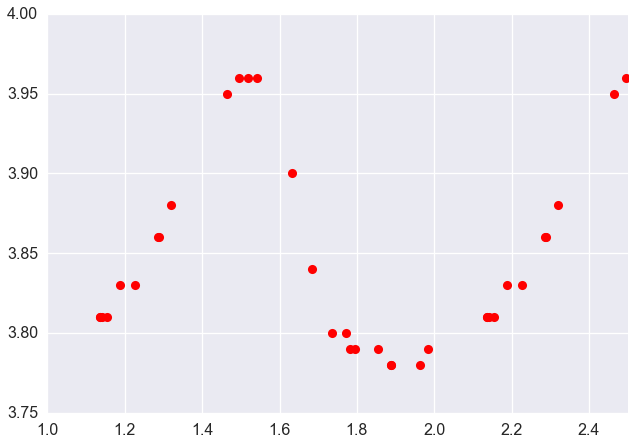

In [264]:
pullmags = df[mag]
pullphase = df['phase']

plotmag = pullmags[pullmags<50]
plotphase = pullphase[pullmags<50]

plotmag = np.concatenate((plotmag,plotmag,plotmag,plotmag,plotmag))
plotphase = np.concatenate((plotphase,(plotphase+1.0),(plotphase+2.0),(plotphase+3.0),(plotphase+4.0)))
print len(plotphase), len(plotmag)


mp.plot(x,data1,'k-', zorder=4)
mp.plot(plotphase, plotmag,'ro',ls='None')
mp.xlim(1,2.5)


In [265]:
data1

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

In [270]:
fit_errs

array([ 0.  ,  0.01,  0.01,  0.01,  0.  ,  0.  ,  0.  ,  0.01,  0.01,
        0.  ,  0.01,  0.  ,  0.  ,  0.01,  0.  ,  0.01,  0.01,  0.01,
        0.  ,  0.01,  0.01,  0.  ,  0.01,  0.01])

In [288]:
os.getcwd()

'/Users/vs/Dropbox/CHP/Galactic_Cepheids'

In [330]:
new_file  = 'AQPup' + '.gloess_in'
linecache.clearcache()
smooth_line = linecache.getline(new_file, 4).strip()
smooth_line = re.sub("[\[\]\'\",]"," ", smooth_line)
smooth = smooth_line.split()


In [331]:
smooth

['0.10',
 '0.10',
 '0.10',
 '0.10',
 '0.10',
 '0.20',
 '0.20',
 '0.20',
 '1.20',
 '0.20',
 '0.20',
 '0.20']

In [292]:
new_file

'AQPup.gloess_in'

In [329]:
gal_df

,Cepheid,logP,mag_U,err_U,amp_U,mag_B,err_B,amp_B,mag_V,err_V,...,amp_3p6,mag_4p5,err_4p5,amp_4p5,mag_5p8,err_5p8,amp_5p8,mag_8p0,err_8p0,amp_8p0
0,RT Aur,0.571489,6.609357,0.019773,1.354039,6.143806,0.016068,1.084971,5.508104,0.010650,...,0.179597,3.850381,0.003019,0.197519,NaN,NaN,NaN,NaN,NaN,NaN
1,QZ Nor,0.578244,10.442357,0.008860,0.750000,9.782436,0.006695,0.436861,8.875280,0.004498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SU Cyg,0.584952,7.819801,0.015942,1.074262,7.491049,0.015154,1.014695,6.891246,0.010821,...,0.687969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Y Lac,0.635863,10.408789,0.017697,1.141546,9.921068,0.015776,1.033274,9.163285,0.010982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,T Vul,0.646934,6.823004,0.016773,1.076058,6.442697,0.014388,0.970065,5.773366,0.009364,...,0.179151,4.113350,0.002859,0.186753,NaN,NaN,NaN,NaN,NaN,NaN
5,FF Aql,0.650397,6.656006,0.008511,0.556764,6.158180,0.007186,0.474795,5.383314,0.004925,...,0.071190,3.353535,0.001026,0.065695,NaN,NaN,NaN,NaN,NaN,NaN
6,T Vel,0.666501,9.643739,0.017379,1.206651,8.948792,0.013096,0.928630,8.046931,0.008828,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,VZ Cyg,0.687034,10.523868,0.018508,1.249960,9.897502,0.014845,1.014418,8.979768,0.009754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,V350 Sgr,0.712165,9.087347,0.019631,1.336694,8.445599,0.015489,1.058716,7.500000,0.010373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,BG Lac,0.726883,10.555048,0.016687,1.129262,9.880392,0.012966,0.879827,8.898654,0.008618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
np.nansum(df.Reference)

0.0

In [ ]:
cepID, df, sm_params = gloess_setup('RT Aur')
mag = 'mag_B'
err = 'err_B'

In [155]:
df.loc[df[err]==9.99, mag].where(df[mag]==0)

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
       ..
319   NaN
320   NaN
321   NaN
322   NaN
323   NaN
324   NaN
325   NaN
326   NaN
327   NaN
328   NaN
329   NaN
330   NaN
331   NaN
332   NaN
333   NaN
334   NaN
335   NaN
336   NaN
337   NaN
338   NaN
339   NaN
340   NaN
341   NaN
342   NaN
343   NaN
344   NaN
345   NaN
346   NaN
347   NaN
348   NaN
Name: mag_J, dtype: float64